In [1]:
  # calcula as probabilidades utilizando naive bayes
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler



### Exploracao dos Dados


In [2]:
from zipfile import ZipFile

path_file = '/home/steve/git/public_data/ge_df_users_editorias.csv.zip'
#df = pd.read_csv(path_file, compression='zip')

zip_file = ZipFile(path_file)
datasets = {text_file.filename: pd.read_csv(zip_file.open(text_file.filename)) 
       for text_file in zip_file.infolist() if text_file.filename.endswith('.csv')}

datasets.keys()

dataset = datasets['ge_df_users_editorias.csv']

dataset.describe()



,user,dias,pviews,visitas,tempo_total,dias_desktop,pviews_desktop,visitas_desktop,tempo_total_desktop,futebol_desktop,...,olimp_tenis_mobile,olimp_canoagem_mobile,olimp_box_mobile,motor_mobile,placar_ge_mobile,volei_mobile,atletismo_mobile,idade,cartola_pro,cartola
count,5.068900e+04,50689.000000,50689.000000,50689.000000,50689.000000,50689.000000,50689.000000,50689.000000,50689.000000,50689.000000,...,50689.000000,50689.000000,50689.0,50689.000000,50689.0,50689.000000,50689.000000,22616.000000,50689.000000,50689.000000
mean,5.678938e+07,8.538085,56.689459,17.148415,12637.405687,5.301900,40.405591,9.963345,10092.362449,2902.345333,...,18.268388,11.536675,0.0,3.899356,0.0,2.186681,2.266822,29.308719,0.021602,0.593738
std,1.608739e+07,8.201193,109.424394,24.828745,27908.554735,7.191982,95.980044,18.279669,26132.229710,9772.275181,...,240.150300,160.436603,0.0,79.725056,0.0,51.366270,48.094947,49.140567,0.145383,0.491139
min,1.912357e+06,1.000000,1.000000,1.000000,45.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,-7161.000000,0.000000,0.000000
25%,4.527815e+07,2.000000,4.000000,2.000000,180.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,22.000000,0.000000,0.000000
50%,5.935156e+07,5.000000,15.000000,7.000000,1671.576000,2.000000,5.000000,2.000000,235.572000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,27.000000,0.000000,1.000000
75%,7.042032e+07,13.000000,58.000000,21.000000,10349.220999,8.000000,33.000000,11.000000,5849.203000,815.503000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,35.000000,0.000000,1.000000
max,5.000061e+08,31.000000,2143.000000,277.000000,225690.794000,31.000000,1721.000000,229.000000,225690.794000,186316.804000,...,12717.714000,12597.324000,0.0,6908.499000,0.0,7476.575000,4304.594000,236.000000,1.000000,1.000000


In [3]:

# existem valores null?
dataset.isnull().values.any()
#dataset.isnull().sum()
print(dataset.isna().sum())

# temos que avaliar se dropamos. Existem muitos valores nan

user               0
dias               0
pviews             0
visitas            0
tempo_total        0
               ...  
uf             29130
idade          28073
cartola_pro        0
cartola            0
device             0
Length: 64, dtype: int64


In [3]:
dataset.dtypes
dataset.head()

,user,dias,pviews,visitas,tempo_total,dias_desktop,pviews_desktop,visitas_desktop,tempo_total_desktop,futebol_desktop,...,placar_ge_mobile,volei_mobile,atletismo_mobile,tipo,sexo,uf,idade,cartola_pro,cartola,device
0,1912357,12,31,20,3868.477,4,13,5,2714.085,0.000,...,0,0.000,0.000,NaN,NaN,NaN,NaN,0,0,pc_e_m
1,1914630,2,8,5,427.352,2,8,5,427.352,201.338,...,0,0.000,0.000,NaN,NaN,NaN,NaN,0,0,pc_only
2,1915241,14,44,23,14758.755,12,39,20,13797.929,3907.171,...,0,0.000,0.000,NaN,NaN,NaN,NaN,0,0,pc_e_m
3,1919933,1,1,1,45.000,0,0,0,0.000,0.000,...,0,0.000,0.000,NaN,NaN,NaN,NaN,0,1,m_only
4,1921860,21,88,44,47626.636,11,53,25,40495.469,45.000,...,0,193.252,74.133,NaN,NaN,NaN,NaN,0,0,pc_e_m


### Aplicamos o Algoritmo Apriori

In [4]:
# dropamos dados nao necesarios


dataset_regras = dataset.drop(['user', 'dias', 'pviews', 'visitas', 'tempo_total',
                                'dias_desktop', 'pviews_desktop', 'visitas_desktop',
                                'tempo_total_desktop', 'tipo', 'sexo', 'uf', 'idade',
                                'cartola', 'cartola_pro', 'device', 'tempo_total',
                               'dias_mobile', 'pviews_mobile','visitas_mobile', 'tempo_total_mobile'], axis=1)

column_names = list(dataset_regras.columns)

dataset_regras.head()
#dataset_regras.describe()


,futebol_desktop,home_desktop,cartola_desktop,futebol_internacional_desktop,olimp_futebol_desktop,olimp_home_e_noticias_desktop,olimp_atletismo_desktop,olimp_ginastica_desktop,olimp_natacao_desktop,olimp_basquete_desktop,...,olimp_vole_praia_mobile,olimp_handebol_mobile,olimp_saltos_orn_mobile,olimp_tenis_mobile,olimp_canoagem_mobile,olimp_box_mobile,motor_mobile,placar_ge_mobile,volei_mobile,atletismo_mobile
0,0.000,0.0,0.0,0.000,45.000,68.665,45.000,2372.455,0.000,0.000,...,45.000,0.0,0.0,0.0,0.000,0,0.0,0,0.000,0.000
1,201.338,0.0,0.0,45.000,45.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.0,0.0,0.0,0.000,0,0.0,0,0.000,0.000
2,3907.171,0.0,0.0,0.000,1331.544,91.721,1790.473,0.000,90.000,0.000,...,0.000,0.0,0.0,0.0,0.000,0,0.0,0,0.000,0.000
3,0.000,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.0,0.0,0.0,0.000,0,0.0,0,0.000,0.000
4,45.000,0.0,0.0,2370.211,20.845,45.000,45.000,1630.240,4261.333,4948.996,...,290.533,0.0,0.0,0.0,697.862,0,0.0,0,193.252,74.133


In [5]:
!pip install apyori
from apyori import apriori


In [6]:

def convert_transactions(data):
  observations = []
  rows = len(data)
  cols = len(data.columns)

  for i in range(0, rows):
    lst = []
    for j in range(0, cols):     
      if data.values[i,j] > 0:
        lst.append(str(data.columns[j]))
      else:
        lst.append('NaN')
    observations.append(lst)
  
  return observations

transactions = convert_transactions(dataset_regras[:100])
transactions

'''
transactions = pd.DataFrame(transactions)
transactions.fillna('nan')
transactions = np.array(transactions.values)
transactions.tolist()
'''
total = len(transactions)
print('total observations ', total)
# 50689/60 
associations = apriori(transactions, min_length = 2, min_support = 0.1, min_confidence = 0.2, min_lift = 3)
results = list(associations)
results

results = [list(x) for x in results]
  
results_format = []

for i in range(len(results)):
  results_format.append([list(x) for x in results[i][2]])

print(results_format)


total observations  100
[[[frozenset({'futebol_mobile'}), frozenset({'home_mobile'}), 0.5769230769230769, 3.205128205128205], [frozenset({'home_mobile'}), frozenset({'futebol_mobile'}), 0.8333333333333334, 3.2051282051282053]], [[frozenset({'home_mobile'}), frozenset({'olimp_atletismo_mobile'}), 0.6111111111111112, 3.395061728395062], [frozenset({'olimp_atletismo_mobile'}), frozenset({'home_mobile'}), 0.6111111111111112, 3.395061728395062]], [[frozenset({'home_mobile'}), frozenset({'olimp_basquete_mobile'}), 0.6111111111111112, 3.5947712418300655], [frozenset({'olimp_basquete_mobile'}), frozenset({'home_mobile'}), 0.6470588235294117, 3.594771241830065]], [[frozenset({'home_mobile'}), frozenset({'olimp_ginastica_mobile'}), 0.6111111111111112, 3.395061728395062], [frozenset({'olimp_ginastica_mobile'}), frozenset({'home_mobile'}), 0.6111111111111112, 3.395061728395062]], [[frozenset({'home_mobile'}), frozenset({'olimp_vole_praia_mobile'}), 0.5555555555555556, 3.4722222222222223], [frozens

### Olhamos dados correlacionados

In [4]:
# preparamos os dados
X = dataset.drop(['user', 'dias', 'pviews', 'visitas', 'tempo_total', 'tipo', 'sexo', 'uf', 'idade',
                                'cartola', 'device', 'tempo_total'], axis=1)

#                                'dias_desktop', 'pviews_desktop', 'visitas_desktop', 'tempo_total_desktop',
#                                'dias_mobile', 'pviews_mobile', 'visitas_mobile', 'tempo_total_mobile'], axis=1)

y = dataset["cartola_pro"]

column_names = list(X.columns)


In [ ]:
#observamos que dados estão correlacionados com cartola pro
corr_matrix = X.corr()
fix, ax = plt.subplots(figsize=(28,30))
sns.heatmap(corr_matrix, annot=True, square=True)
plt.show()

In [12]:
cor_target = abs(corr_matrix['cartola_pro'])
cor_target

# escolhemos as caracteristicas mais relevantes
relevant_features = cor_target[cor_target > 0.5]
relevant_features

# não encontro features relevantes a 'cartola_pro', talves não faz sentido aplicar matriz de correlacao

cartola_pro    1.0
Name: cartola_pro, dtype: float64

In [5]:
# apagamos cartola_pro e olhamos as novas caracteristicas
X = X.drop(['cartola_pro'], 1)
X.head()

,dias_desktop,pviews_desktop,visitas_desktop,tempo_total_desktop,futebol_desktop,home_desktop,cartola_desktop,futebol_internacional_desktop,olimp_futebol_desktop,olimp_home_e_noticias_desktop,...,olimp_vole_praia_mobile,olimp_handebol_mobile,olimp_saltos_orn_mobile,olimp_tenis_mobile,olimp_canoagem_mobile,olimp_box_mobile,motor_mobile,placar_ge_mobile,volei_mobile,atletismo_mobile
0,4,13,5,2714.085,0.000,0.0,0.0,0.000,45.000,68.665,...,45.000,0.0,0.0,0.0,0.000,0,0.0,0,0.000,0.000
1,2,8,5,427.352,201.338,0.0,0.0,45.000,45.000,0.000,...,0.000,0.0,0.0,0.0,0.000,0,0.0,0,0.000,0.000
2,12,39,20,13797.929,3907.171,0.0,0.0,0.000,1331.544,91.721,...,0.000,0.0,0.0,0.0,0.000,0,0.0,0,0.000,0.000
3,0,0,0,0.000,0.000,0.0,0.0,0.000,0.000,0.000,...,0.000,0.0,0.0,0.0,0.000,0,0.0,0,0.000,0.000
4,11,53,25,40495.469,45.000,0.0,0.0,2370.211,20.845,45.000,...,290.533,0.0,0.0,0.0,697.862,0,0.0,0,193.252,74.133


### Desemvolvemos modelos para a tarefa de Classificacao
As caracteristicas estão basados nas categorias esportivas. Esta é uma matriz esparsa com muitos ceros.


In [8]:
from scipy.sparse import csr_matrix
from numpy import array
from numpy import count_nonzero

# % de ceros sparse
# 80% dos datos contem valores cero. Não é bom
sparsity = 1.0 - count_nonzero(X) / X.size
print('Sparsity: ', sparsity)
#print(sparse_dataset)


# comprimimos os dados 
# https://dziganto.github.io/Sparse-Matrices-For-Efficient-Machine-Learning/
sparse_dataset = csr_matrix(X)


Sparsity:  0.8041173399781776


In [14]:
# Aplicamos um modelo linear SVM

from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(sparse_dataset, y, test_size=0.33, random_state=42)

#clf = svm.SVC(kernel='linear', C=1)
model = LinearSVC()
#%timeit svc.fit(dataset_regras, y)
#%timeit svc.fit(X_train, y_train)

model.fit(X_train, y_train)
print(model)
y_pred = model.predict(X_test)

# acuracia 92%
print("\nAccuracy: {}%".format(model.score(X_test, y_test) * 100 ))

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

Accuracy: 91.33787661406025%


/home/steve/miniconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [12]:
# utilizamos outro kernel RBF para a não linearidade.
# Neste caso não converge.
'''
modelrbf = SVC(kernel='rbf', C = 1, gamma=0.1)
modelrbf.fit(X_train, y_train)
y_pred = modelrbf.predict(X_test)
print("Accuracy: {}%".format(modelrbf.score(X_test, y_test) * 100 ))
'''

'\nmodelrbf = SVC(kernel=\'rbf\', C = 1, gamma=0.1)\nmodelrbf.fit(X_train, y_train)\ny_pred = modelrbf.predict(X_test)\nprint("Accuracy: {}%".format(modelrbf.score(X_test, y_test) * 100 ))\n'

### Preferencias para cada Usuario

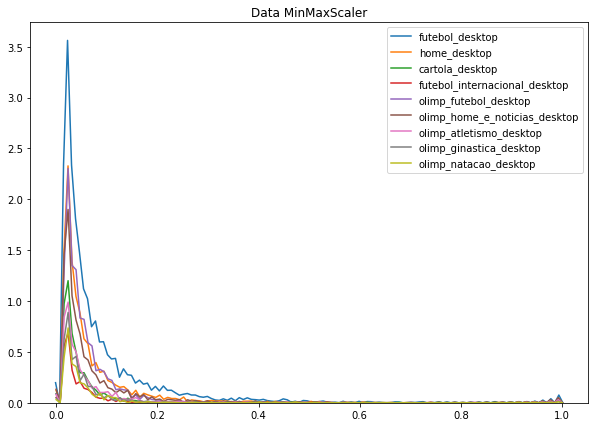

In [18]:
# Scalamos os dados ao rededor da media

from sklearn import preprocessing

fig, ax = plt.subplots(ncols=1, figsize=(10,7))

#X.mean()
#X.plot()
column_names = list(X.columns)
scaler = preprocessing.MinMaxScaler()
data_sc = scaler.fit_transform(X)

X = pd.DataFrame(data_sc, columns=column_names)

# mostramos alguns dados scalados

ax.set_title('Data MinMaxScaler')
sns.kdeplot(df['futebol_desktop'], ax=ax)
sns.kdeplot(df['home_desktop'], ax=ax)
sns.kdeplot(df['cartola_desktop'], ax=ax)
sns.kdeplot(df['futebol_internacional_desktop'], ax=ax)
sns.kdeplot(df['olimp_futebol_desktop'], ax=ax)
sns.kdeplot(df['olimp_home_e_noticias_desktop'], ax=ax)
sns.kdeplot(df['olimp_atletismo_desktop'], ax=ax)
sns.kdeplot(df['olimp_ginastica_desktop'], ax=ax)
sns.kdeplot(df['olimp_natacao_desktop'], ax=ax)

# mostramos as novas estatistiacas
#df.describe()

### Previsao das Preferencias (Instavel)

In [19]:
import pandas as pd
from SLIM import SLIM, SLIMatrix

# matrix esparsa dos dados scalados
X_csr_mat = csr_matrix(X)

X_train, X_test, _, _ = train_test_split(X_csr_mat, y, test_size=0.33, random_state=42)
#leitura de dados <user> <item> <rating>
#traindata = pd.read_csv('~/git/slim/test/train.ijv', delimiter = ' ', header=None)

trainmat = SLIMatrix(X_train)

#set up parameters to learn model, e.g., use Coordinate Descent with L1 and L2
#regularization
params = {'algo':'cd', 'nthreads':2, 'l1r':1.0, 'l2r':1.0}

model = SLIM()
model.train(params, trainmat)


Learning takes 0.311 secs.


In [20]:

#test data
#testdata = pd.read_csv('~/git/slim/test/test.ijv', delimiter = ' ', header=None)

testmat = SLIMatrix(X_test, model)


In [ ]:

#top-10 recomendacoes a partir de matriz esparsa
prediction_res = model.predict(testmat, nrcmds=10, outfile = 'output.txt')
prediction_res


In [ ]:

#dump model
model.save_model(modelfname='model.csr', # filename to save the model as a csr matrix
                 mapfname='map.csr' # filename to save the item map
                )

#load model
model_new = SLIM()
model_new.load_model(modelfname='model.csr', # filename of the model
                 mapfname='map.csr' # filename of the item map
                )